<a href="https://colab.research.google.com/github/Shreegowri/Advanced-Machine-Learning---Project---FineGrainedFoodClassification/blob/master/AMLProject_BaseModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x
import os
import csv
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras import Model
import numpy as np

In [0]:
#!pip install -U -q kaggle
!mkdir .kaggle
from google.colab import files
files.upload()
#os.path.dirname('.kaggle')

In [0]:
import json
token = {"username":"shreegowri","key":"298cff9c4343d6c6c5825f0ceedd6163"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump({"username":"shreegowri","key":"298cff9c4343d6c6c5825f0ceedd6163"}, file)

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets list


In [0]:
!kaggle competitions download -c ifood-2019-fgvc6 #downloads the files into /content/{/content}/competitions/ifood-2019-fgvc6 directory

In [0]:
import zipfile

train_zip = '/content/{/content}/competitions/ifood-2019-fgvc6/train_set.zip'
zip_ref = zipfile.ZipFile(train_zip, 'r')
zip_ref.extractall('train_set')


train_label_zip = '/content/{/content}/competitions/ifood-2019-fgvc6/train_labels.csv.zip'
zip_ref = zipfile.ZipFile(train_label_zip, 'r')
zip_ref.extractall('train_set/train_set')


val_zip = '/content/{/content}/competitions/ifood-2019-fgvc6/val_set.zip'
zip_ref = zipfile.ZipFile(val_zip, 'r')
zip_ref.extractall('val_set')

test_zip = '/content/{/content}/competitions/ifood-2019-fgvc6/test_set.zip'
zip_ref = zipfile.ZipFile(test_zip, 'r')
zip_ref.extractall('test_set')

zip_ref.close()

In [0]:
def load_csv(filename):
  ''' param: filename of the csv file with train or test images names along with respective labels
      return: the path to images and respective labels of the images
  '''
  dirname = os.path.dirname(filename)
  images_path = []
  labels = []
  with open(filename) as f:
    parsed = csv.reader(f, delimiter=",", quotechar="'")
    for row in parsed:
      if row[1]=='label':
        continue
      images_path.append(os.path.join(dirname, row[0]))
      #print(row[1])
      labels.append(int(row[1]))
  return images_path, labels


In [0]:
train_images_path, train_labels = load_csv('/content/train_set/train_set/train_labels.csv')
val_images_path, val_labels = load_csv ('/content/val_set/val_set/val_labels.csv')
len(train_labels)

118475

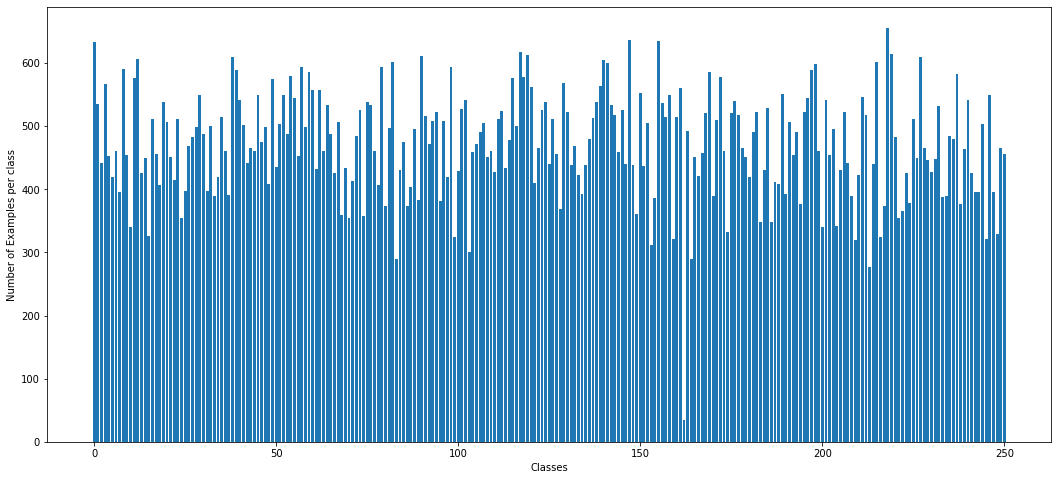

In [0]:
from collections import Counter 
d = Counter(train_labels)
plt.figure(figsize=[18, 8])
plt.bar(d.keys(), d.values())
plt.xlabel("Classes")
plt.ylabel("Number of Examples per class")
plt.show()

In [0]:
#currently not used

def normalize(x):
  ''' param: tensor of image with its label
      return: normalized image with mean 0 and variance 1 (across RGB channels)
  '''
  x = tf.image.per_image_standardization(x) 
  return x

In [0]:
#currently not used

def mean_subtraction(image, means):
  '''param: image tensor of shape [H, W, C], mean values for RGB channels
     returns: centered image
  '''
  if image.get_shape().ndims != 3:
    raise ValueError('Input must be of size [height, width, C>0]')
  num_channels = image.get_shape().as_list()[-1]
  if len(means) != num_channels:
    raise ValueError('len(means) must match the number of channels')

  #channels = tf.split(2, num_channels, image)
  channels = tf.split(image, num_channels, axis=2)
  for i in range(num_channels):
    channels[i] -= means[i]
  return tf.concat(channels, axis=2)

In [0]:
class_names = np.loadtxt('/content/class_list.txt', dtype={'names': ('class_num', 'class_name',), 'formats': ('i4', 'U100')})
class_names[0][1]

'macaron'

In [0]:
HEIGHT = 224
WIDTH = 224
IMG_SHAPE = (HEIGHT, WIDTH, 3)
resize_height = 256
resize_height = 256
means = [123.68, 116.779, 103.939] #ImageNet's mean, change to training data mean

def preprocess_train(x, y):
  ''' param: path to the image with its label
      task: reads image from directory, resizes an image to 256 x 256, then randomly crops to 224 x 224
      return: the augmented and centered data
  '''
  x = tf.io.read_file(x) #read images
  x = tf.image.decode_jpeg(x, dct_method="INTEGER_ACCURATE", channels=3) #decode jpeg images
  x = tf.image.convert_image_dtype(x, tf.float32)
  x = tf.image.resize_with_pad(x, resize_height, resize_height, antialias=False) #Resizes an image to a target width and height by keeping the aspect ratio the same without distortion.
  #x = tf.compat.v1.image.resize_image_with_pad(x, resize_height, resize_height)
  x = tf.image.random_crop(x, [HEIGHT, WIDTH, 3]) #Randomly crops a tensor to a given size
  x = tf.image.random_flip_left_right(x)  #flips the image along width with 0.5 probability
  #x = mean_subtraction(x, means)
  return x,y    
  

In [0]:
#DISTORTED IMAGES

'''def preprocess_val(x, y):
  ''' similar to preprocess_train but uses center crop after resize
  '''
  x = tf.compat.v1.read_file(x)
  x = tf.image.decode_jpeg(x, dct_method="INTEGER_ACCURATE")
  #x = tf.compat.v1.image.resize_image_with_pad(x, resize_height, resize_height)
  #x = tf.image.resize_with_pad(x, resize_height, resize_height, method=ResizeMethod.BILINEAR, antialias=False)
  x = tf.image.resize(x, [resize_height, resize_height])
  x = tf.image.central_crop(x, 0.875)  #as we 224/256 = 0.875 central cropping the image
  #print(x.shape)
  x.set_shape([HEIGHT, WIDTH, 3])
  x = tf.cast(x, tf.float32)
  x = mean_subtraction(x, means) 
  return x, y '''

In [0]:
def preprocess_val(x, y):
  ''' similar to preprocess_train but uses center crop after resize
  '''
  x = tf.io.read_file(x)
  x = tf.image.decode_jpeg(x, dct_method="INTEGER_ACCURATE", channels=3)
  x = tf.image.convert_image_dtype(x, tf.float32)
  #x = tf.compat.v1.image.resize_image_with_pad(x, resize_height, resize_height)
  x = tf.image.resize_with_pad(x, resize_height, resize_height, antialias=False)
  #x = tf.image.resize(x, [resize_height, resize_height])
  x = tf.image.central_crop(x, 0.875)  #as we 224/256 = 0.875 central cropping the image
  #x = x/255.0  #Just black pictures, seems like pixels are already between the range 0-1 
  #x = mean_subtraction(x, means)  #Just black pictures
  #x = normalize(x)
  return x, y 

In [0]:
#define the TF datset with batchsize, shuffling and preprocessing
BATCH_SIZE = 256 #change and see if performance improves, 1024 resource not enough
num_train_examples = len(train_images_path)
Num_Classes = len(set(train_labels))
train_dataset = tf.data.Dataset.from_tensor_slices((train_images_path, train_labels)).shuffle(num_train_examples).map(preprocess_train).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_images_path, val_labels)).map(preprocess_val).batch(128)

In [0]:
Num_Classes

251

In [0]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(15,15))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(class_names[label_batch[n]][1])
      plt.axis('off')
  plt.show()
  #print(image_batch[1][100:200, 100:200, :])
  #print(np.sum(image_batch[1], axis=2))

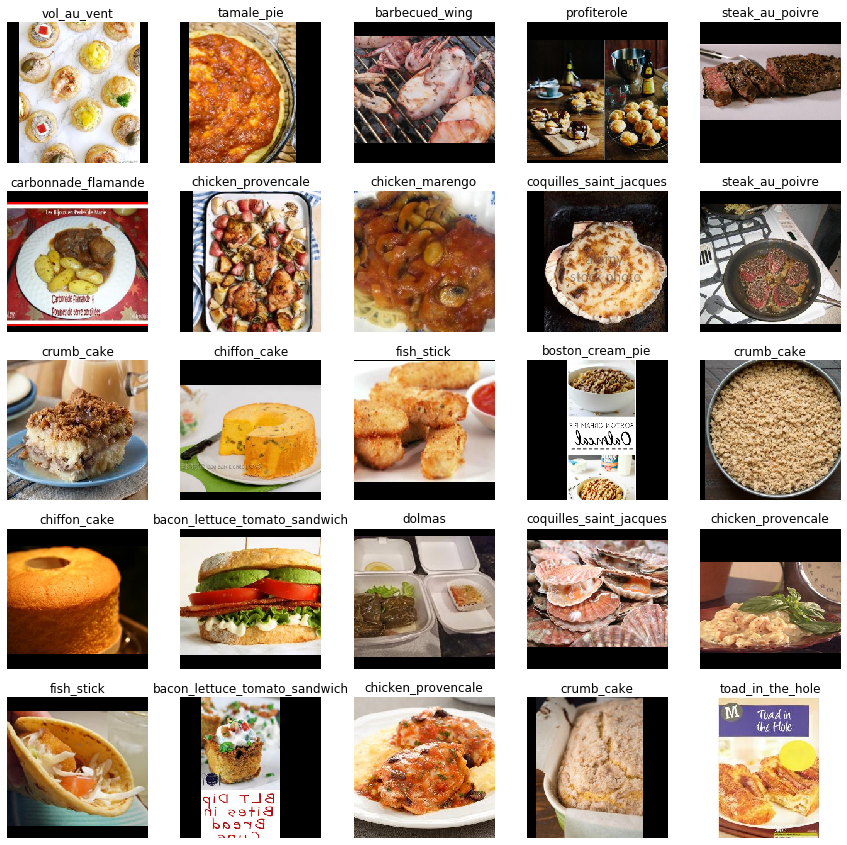

In [0]:
'''image_batch, label_batch = next(train_dataset)
show_batch(image_batch, label_batch)

iterator = train_dataset.make_one_shot_iterator()
images, labels = iterator.get_next()'''


for image, label in train_dataset.take(1):
  show_batch(image, label)

In [0]:
#instantiate the resnet50 version 2 model with ImageNet weights and seting layers as non trainable

base_model = tf.keras.applications.ResNet50V2(input_shape=IMG_SHAPE, weights = "imagenet", include_top = False) #input_shape = (224,224,3),
for layer in base_model.layers:
  layer.trainable = False
#base_model.trainable = False 

last_layer = base_model.get_layer('post_relu')
last_output = last_layer.output
base_model.summary()

94674944/94668760 [==============================] - 3s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
________________________

In [0]:
#Attach the top layers including pooling, dropout and dense layers

x = tf.keras.layers.GlobalAveragePooling2D(name='avg_pool')(last_output)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(Num_Classes, activation='softmax', name='prediction')(x)
model = tf.keras.models.Model(base_model.input, x, name='model')

In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [0]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [0]:
#Adding tensorboard callbacks

from tensorflow.keras.callbacks import TensorBoard
import datetime

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = TensorBoard(log_dir=log_dir, update_freq='batch', histogram_freq=1)


In [0]:
#Train the model
num_epochs = 100
model.compile(optimizer = tf.keras.optimizers.SGD(momentum=0.9), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_dataset, epochs = num_epochs, validation_data = val_dataset, callbacks = [tensorboard_callback])

In [0]:
#%load_ext tensorboard

%tensorboard --logdir logs/fit

In [0]:
#Train the model using adam optimizer
num_epochs = 100
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_dataset, epochs = num_epochs, validation_data = val_dataset, callbacks = [tensorboard_callback])

In [0]:
%tensorboard --logdir logs/fit